#### **Declare path to project directory**

In [1]:
# path_to_directory = "/home/antonio/ist/data-science/proj/forecasting"
path_to_directory = "/home/morais/data_science_project"

#### **Declare filename of the dataset to be used (and other parameters)**

In [2]:
file_tag: str = "forecast_gdp_europe"
filename: str = f"{path_to_directory}/datasets/{file_tag}_scaling.csv"
target: str = "GDP"
timecol: str = "Year"

# **Forecasting**
## **Training**

In [3]:
from pandas import Series
from math import sqrt
from dslabs_functions import plot_multibar_chart, FORECAST_MEASURES, HEIGHT, Axes, subplots, set_chart_labels, BarContainer, ndarray, FONT_TEXT
from numpy import arange


def series_train_test_split(data: Series, trn_pct: float = 0.90) -> tuple[Series, Series]:
    trn_size: int = int(len(data) * trn_pct)
    df_cp: Series = data.copy()
    train: Series = df_cp.iloc[:trn_size, -1]
    test: Series = df_cp.iloc[trn_size:, -1]
    return train, test

def plot_multibar_chart(
    group_labels: list,
    yvalues: dict,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    percentage: bool = False,
) -> Axes | list[Axes]:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    bar_labels: list = list(yvalues.keys())

    # This is the location for each bar
    index: ndarray = arange(len(group_labels))
    bar_width: float = 0.8 / len(bar_labels)
    ax.set_xticks(index + bar_width / 2, labels=group_labels)

    for i in range(len(bar_labels)):
        bar_yvalues = yvalues[bar_labels[i]]
        values: BarContainer = ax.bar(
            index + i * bar_width,
            bar_yvalues,
            width=bar_width,
            label=bar_labels[i],
        )
        format = "%.2f" if percentage else "%.2f"  # Updated format for better precision
        ax.bar_label(values, fmt=format, fontproperties=FONT_TEXT)
        if any(y < 0 for y in bar_yvalues) and percentage:
            ax.set_ylim(-1.0, 1.0)
    ax.legend(fontsize="xx-small")

    return ax

def plot_forecasting_eval(trn: Series, tst: Series, prd_trn: Series, prd_tst: Series, title: str = "") -> list[Axes]:
    ev1: dict = {
        "RMSE": [sqrt(FORECAST_MEASURES["MSE"](trn, prd_trn)), sqrt(FORECAST_MEASURES["MSE"](tst, prd_tst))],
        "MAE": [FORECAST_MEASURES["MAE"](trn, prd_trn), FORECAST_MEASURES["MAE"](tst, prd_tst)],
    }
    ev2: dict = {
        "MAPE": [FORECAST_MEASURES["MAPE"](trn, prd_trn), FORECAST_MEASURES["MAPE"](tst, prd_tst)],
        "R2": [FORECAST_MEASURES["R2"](trn, prd_trn), FORECAST_MEASURES["R2"](tst, prd_tst)],
    }

    # print(eval1, eval2)
    fig, axs = subplots(1, 2, figsize=(1.5 * HEIGHT, 0.75 * HEIGHT), squeeze=True)
    fig.suptitle(title)
    plot_multibar_chart(["train", "test"], ev1, ax=axs[0], title="Scale-dependent error", percentage=False)
    plot_multibar_chart(["train", "test"], ev2, ax=axs[1], title="Percentage error", percentage=True)

    return axs

## **Simple Average**

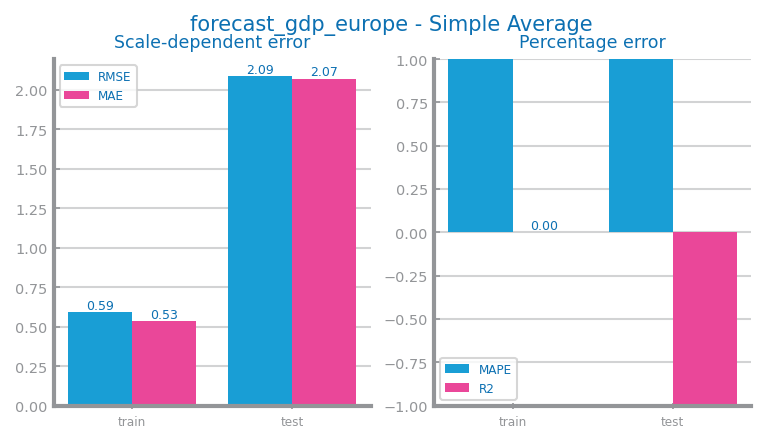

In [4]:
from sklearn.base import RegressorMixin
from matplotlib.pyplot import savefig


class SimpleAvgRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.mean: float = 0.0
        return

    def fit(self, X: Series):
        self.mean = X.mean()
        return

    def predict(self, X: Series) -> Series:
        prd: list = len(X) * [self.mean]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series
    

from pandas import read_csv, DataFrame, Series

# file_tag: str = "ASHRAE"
# filename: str = "data/time_series/ashrae.csv"
# target: str = "meter_reading"
# timecol: str = "timestamp"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]

train, test = series_train_test_split(data, trn_pct=0.80)

fr_mod = SimpleAvgRegressor()
fr_mod.fit(train)
prd_trn: Series = fr_mod.predict(train)
prd_tst: Series = fr_mod.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Simple Average")
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results obtained with Simple Average model.png", bbox_inches='tight')

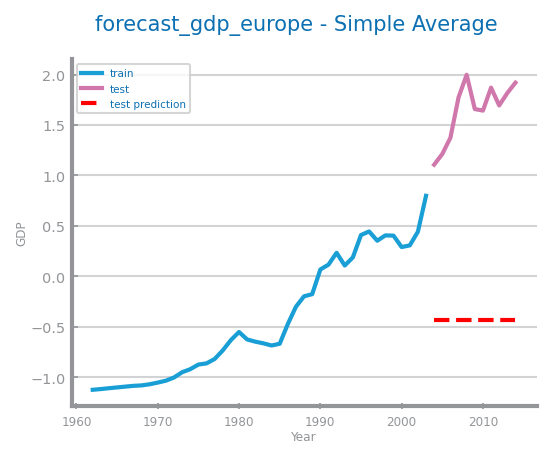

In [5]:
from dslabs_functions import PAST_COLOR, FUTURE_COLOR, PRED_FUTURE_COLOR

def plot_forecasting_series(
    trn: Series,
    tst: Series,
    prd_tst: Series,
    title: str = "",
    xlabel: str = "time",
    ylabel: str = "",
) -> list[Axes]:
    # fig, ax = subplots(1, 1, figsize=(4 * HEIGHT, HEIGHT), squeeze=True)
    fig, ax = subplots(1, 1, squeeze=True)
    fig.suptitle(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(trn.index, trn.values, label="train", color=PAST_COLOR)
    ax.plot(tst.index, tst.values, label="test", color=FUTURE_COLOR)
    ax.plot(prd_tst.index, prd_tst.values, "--", label="test prediction", color=PRED_FUTURE_COLOR)
    ax.legend(prop={"size": 5})

    return ax


plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Simple Average",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots obtained with Simple Average model.png", bbox_inches='tight')

## **Persistence Model**
### Long Term

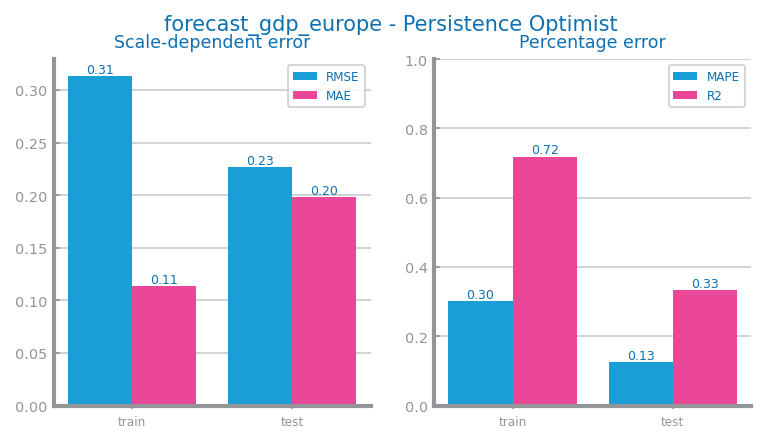

In [6]:
from pandas import Series
from sklearn.base import RegressorMixin


class PersistenceOptimistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last: float = 0.0
        return

    def fit(self, X: Series):
        self.last = X.iloc[-1]
        # print(self.last)
        return

    def predict(self, X: Series):
        prd: list = X.shift().values.ravel()
        prd[0] = self.last
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series
    
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig

# filename: str = "data/time_series/ashrae.csv"
# file_tag: str = "ASHRAE"
# target: str = "meter_reading"
# timecol: str = "timestamp"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]

train, test = series_train_test_split(data, trn_pct=0.80)

fr_mod = PersistenceOptimistRegressor()
fr_mod.fit(train)
prd_trn: Series = fr_mod.predict(train)
prd_tst: Series = fr_mod.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Persistence Optimist")
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results obtained with Persistence model (long term).png", bbox_inches='tight')

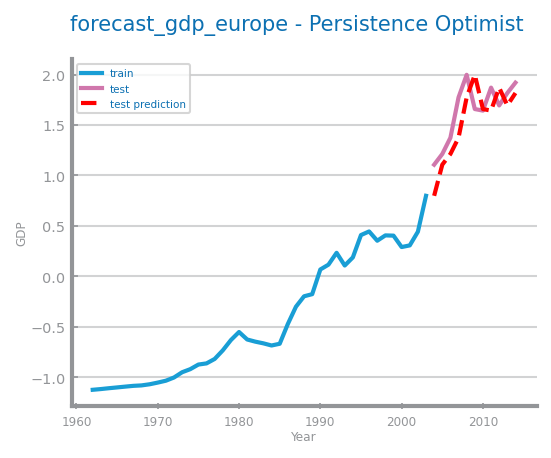

In [7]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Persistence Optimist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots obtained with Persistence model (long term).png", bbox_inches='tight')

### One-set-behind

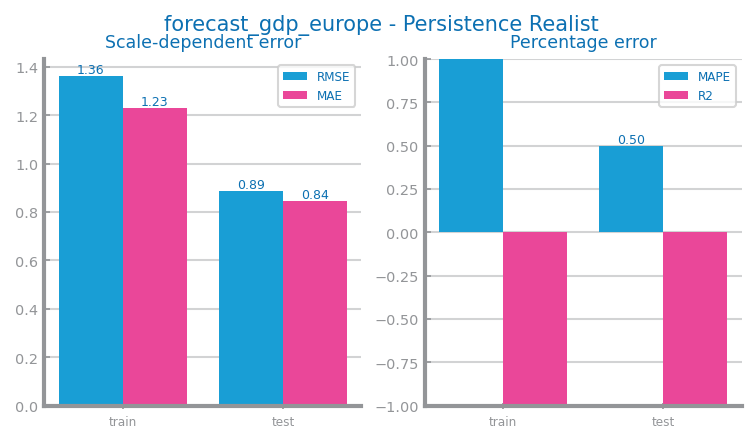

In [8]:
class PersistenceRealistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last = 0
        self.estimations = [0]
        self.obs_len = 0

    def fit(self, X: Series):
        for i in range(1, len(X)):
            self.estimations.append(X.iloc[i - 1])
        self.obs_len = len(self.estimations)
        self.last = X.iloc[len(X) - 1]
        prd_series: Series = Series(self.estimations)
        prd_series.index = X.index
        return prd_series

    def predict(self, X: Series):
        prd: list = len(X) * [self.last]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series
    
fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train)
prd_trn: Series = fr_mod.predict(train)
prd_tst: Series = fr_mod.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Persistence Realist")
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results obtained with Persistence model (one-set-behind).png", bbox_inches='tight')

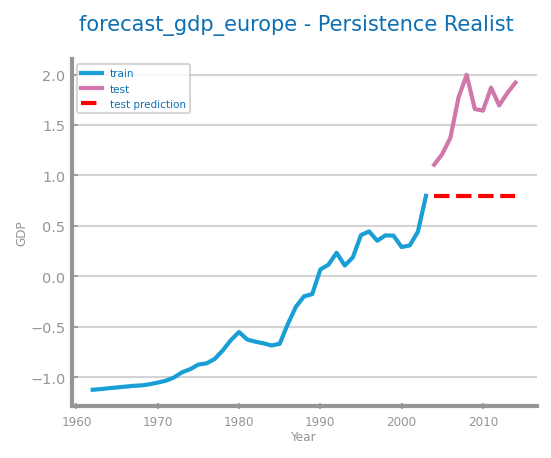

In [9]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots obtained with Persistence model (one-set-behind).png", bbox_inches='tight')

## **Exponential Smoothing**

Exponential Smoothing best with alpha=1 -> R2=-10.054333794585371


/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/s

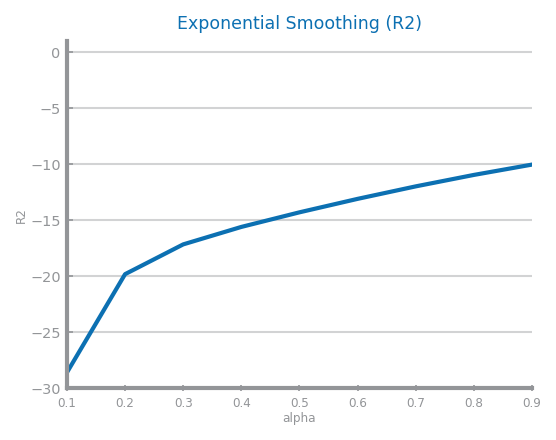

In [10]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, set_chart_xticks, LINE_COLOR, FILL_COLOR, std, gca

def plot_line_chart(
    xvalues: list,
    yvalues: list,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    name: str = "",
    percentage: bool = False,
    show_stdev: bool = False,
) -> Axes:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    ax = set_chart_xticks(xvalues, ax, percentage=percentage)
    if any(y < 0 for y in yvalues) and percentage:
            ax.set_ylim(-30.0, 1.0)
    ax.plot(xvalues, yvalues, c=LINE_COLOR, label=name)
    if show_stdev:
        stdev: float = round(std(yvalues), 3)
        y_bottom: list[float] = [(y - stdev) for y in yvalues]
        y_top: list[float] = [(y + stdev) for y in yvalues]
        ax.fill_between(xvalues, y_bottom, y_top, color=FILL_COLOR, alpha=0.2)
    return ax


def exponential_smoothing_study(train: Series, test: Series, measure: str = "R2"):
    alpha_values = [i / 10 for i in range(1, 10)]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Exponential Smoothing", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for alpha in alpha_values:
        tool = SimpleExpSmoothing(train)
        model = tool.fit(smoothing_level=alpha, optimized=False)
        prd_tst = model.forecast(steps=len(test))

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (alpha,)
            best_model = model
        yvalues.append(eval)

    print(f"Exponential Smoothing best with alpha={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        alpha_values,
        yvalues,
        title=f"Exponential Smoothing ({measure})",
        xlabel="alpha",
        ylabel=measure,
        percentage=flag,
    )

    return best_model, best_params


# filename: str = "data/time_series/ashrae.csv"
# file_tag: str = "ASHRAE"
# target: str = "meter_reading"
# timecol: str = "timestamp"
measure: str = "R2"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]
train, test = series_train_test_split(data, trn_pct=0.80)

best_model, best_params = exponential_smoothing_study(train, test, measure=measure)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting study over different parameterisations of the Exponential Smoothing algorithm.png", bbox_inches='tight')

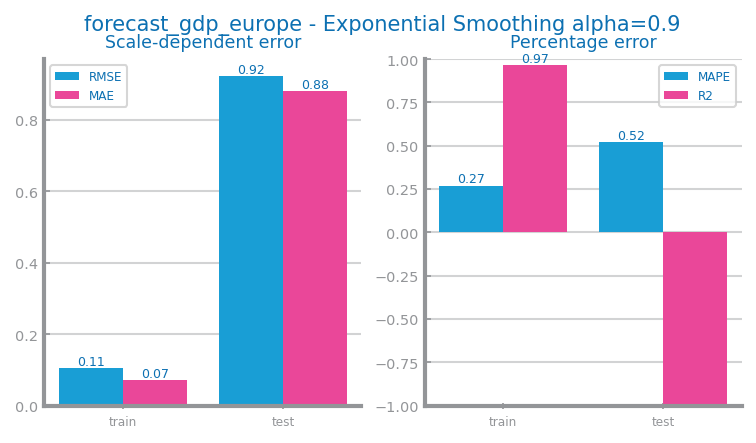

In [11]:
params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Exponential Smoothing alpha={params[0]}")
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results obtained with the best parameterisation of Exponential Smoothing algorithm.png", bbox_inches='tight')

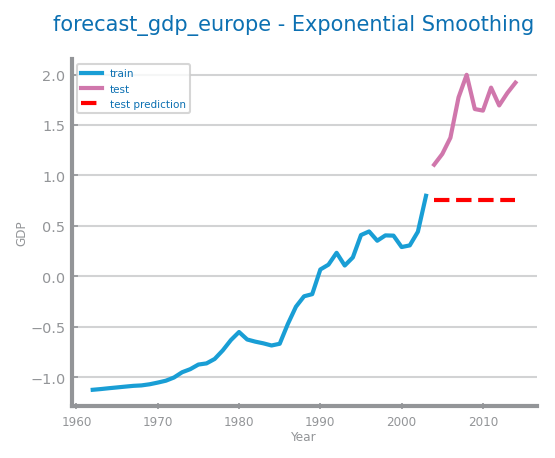

In [12]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Exponential Smoothing ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots obtained with the best parameterisation of Exponential Smoothing algorithm.png", bbox_inches='tight')

## **Rolling Mean**

Rolling Mean best with win=1 -> R2=-9.228544008231882
[-9.228544008231882, -16.700963913048188, -18.69753646597332, -25.02116445654166, -48.77889156256646, -55.43526657881648, -55.661918471404164, -55.661918471404164]


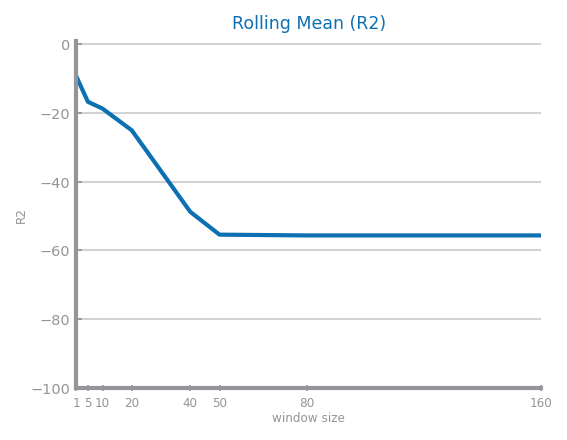

In [13]:
from numpy import mean
from pandas import Series
from sklearn.base import RegressorMixin
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, savefig

def plot_line_chart(
    xvalues: list,
    yvalues: list,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    name: str = "",
    percentage: bool = False,
    show_stdev: bool = False,
) -> Axes:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    ax = set_chart_xticks(xvalues, ax, percentage=percentage)
    if any(y < 0 for y in yvalues) and percentage:
            ax.set_ylim(-100.0, 1.0)
    ax.plot(xvalues, yvalues, c=LINE_COLOR, label=name)
    if show_stdev:
        stdev: float = round(std(yvalues), 3)
        y_bottom: list[float] = [(y - stdev) for y in yvalues]
        y_top: list[float] = [(y + stdev) for y in yvalues]
        ax.fill_between(xvalues, y_bottom, y_top, color=FILL_COLOR, alpha=0.2)
    return ax

class RollingMeanRegressor(RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win
        self.memory: list = []

    def fit(self, X: Series):
        self.memory = X.iloc[-self.win_size :]
        # print(self.memory)
        return

    def predict(self, X: Series):
        estimations = self.memory.tolist()
        predictions = []
        for _ in range(len(X)):
            new_value = mean(estimations[-self.win_size:])  # Use only the last `win_size` values
            estimations.append(new_value)  # Update the memory with the new value
            predictions.append(new_value)  # Store the prediction
        prd_series: Series = Series(predictions, index=X.index)  # Ensure the index matches the input
        return prd_series

    

def rolling_mean_study(train: Series, test: Series, measure: str = "R2"):
    win_size = (1, 5, 10, 20, 40, 50, 80, 160)
    # win_size = (12, 24, 48, 96, 192, 384, 768)
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Rolling Mean", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for w in win_size:
        pred = RollingMeanRegressor(win=w)
        pred.fit(train)
        prd_tst = pred.predict(test)

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (w,)
            best_model = pred
        yvalues.append(eval)

    print(f"Rolling Mean best with win={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    print(yvalues)
    plot_line_chart(
        win_size, yvalues, title=f"Rolling Mean ({measure})", xlabel="window size", ylabel=measure, percentage=flag
    )

    return best_model, best_params


data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]

train, test = series_train_test_split(data, trn_pct=0.80)

# fig = figure(figsize=(HEIGHT, HEIGHT))
fig = figure()
best_model, best_params = rolling_mean_study(train, test)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting study over different parameterisations of the Rolling Mean algorithm.png", bbox_inches='tight')

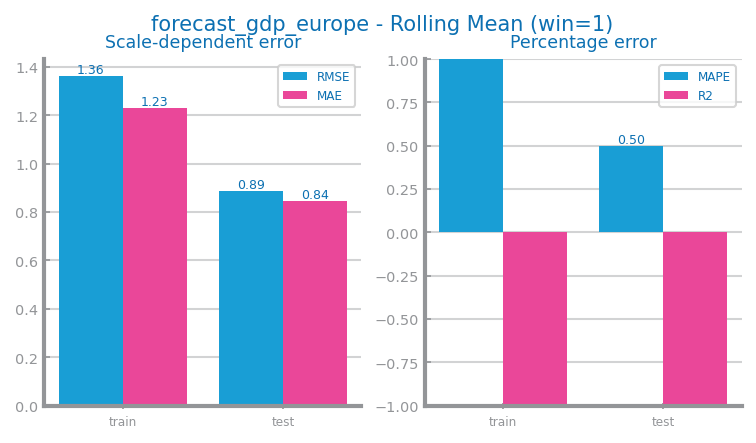

In [14]:
params = best_params["params"]
prd_trn: Series = best_model.predict(train)
prd_tst: Series = best_model.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Rolling Mean (win={params[0]})")
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results obtained with the best parameterisation of Rolling Mean algorithm.png", bbox_inches='tight')

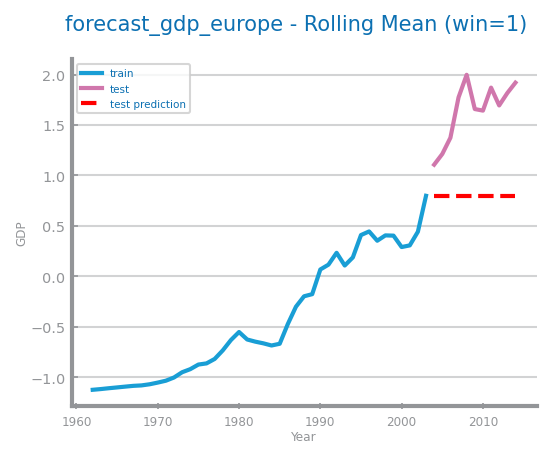

In [15]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Rolling Mean (win={params[0]})",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots obtained with the best parameterisation of Rolling Mean algorithm.png", bbox_inches='tight')

## **Linear Regression**

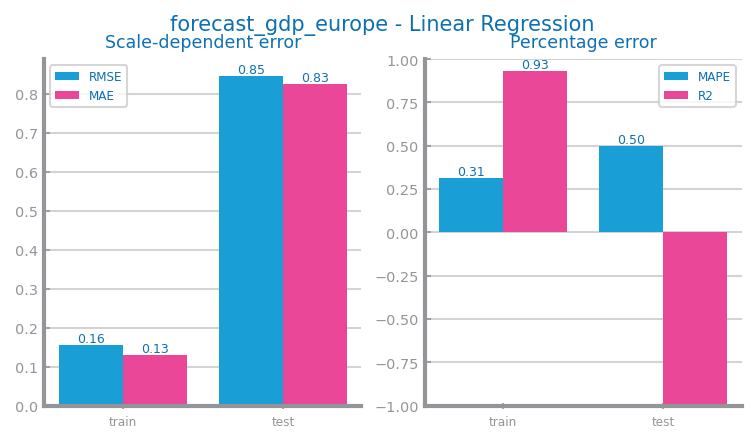

In [16]:
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
# from dslabs_functions import series_train_test_split, plot_forecasting_eval

# filename: str = "data/time_series/ashrae.csv"
# file_tag: str = "ASHRAE"
# target: str = "meter_reading"
# timecol: str = "timestamp"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]
train, test = series_train_test_split(data, trn_pct=0.80)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(data)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results obtained with Linear Regression model.png", bbox_inches='tight')

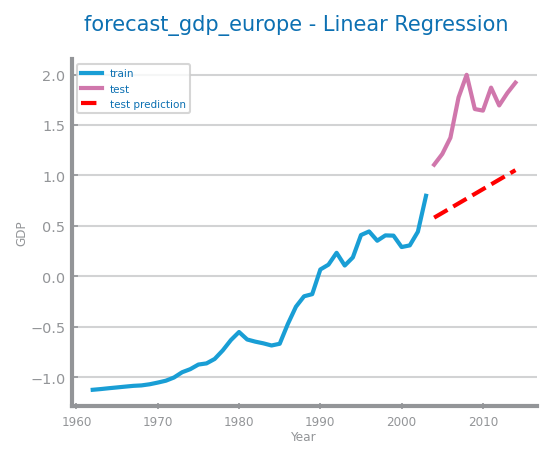

In [17]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots obtained with Linear Regression model.png", bbox_inches='tight')

## **ARIMA**
### Only with target variable

In [18]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.arima.model import ARIMA
# from dslabs_functions import series_train_test_split, HEIGHT

# filename: str = "data/time_series/ashrae.csv"
# file_tag: str = "ASHRAE"
# target: str = "meter_reading"
# timecol: str = "timestamp"
# measure: str = "R2"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]
train, test = series_train_test_split(data, trn_pct=0.80)

# predictor = ARIMA(train, order=(3, 1, 2))
# model = predictor.fit()
# print(model.summary())

In [19]:
# model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))

/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/s

{1: [-8.269520266188312, -7.977252205423417, -5.610057408729445, -3.296473498868056, -4.58906259447693, -5.08932777323074], 3: [-7.875502915548536, -7.630596213802766, -7.447746477174899, -5.927228244131468, -4.538511368279615, -4.495905695683382], 5: [-5.239496380176667, -5.396694141132952, -4.732780318563388, -6.220139409821246, -7.044805365638471, -8.526135079483192], 7: [-4.159730333949532, -5.2197660734527505, -5.502458510244055, -8.07522626642283, -9.791117105263684, -10.168866662905364]}


/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/morais/data_science_project/.venv/l

{1: [-4.578561319366303, -4.595946205692189, -5.34740186338933, -2.9819332429317087, -3.2730756213893404, -5.753656633373381], 3: [-5.787357075011836, -2.0148639396101555, -4.089604807564345, -4.389915299956691, -5.517609768841205, -4.878303789815926], 5: [-5.657289757127173, -5.467281706960863, -3.6938620041084693, -1.6268734788522545, -4.789445490427523, -3.961520795731219], 7: [-3.3460416700766658, -5.201893931438211, -4.74751349025332, -2.0668042721280533, -3.5392509554625455, -4.198988319229735]}


/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/morais/data_science_project/.venv/l

{1: [-1.6287331619481655, -1.9861333867778095, -1.7170134472307321, -2.03462156576321, -1.5803338558602031, -2.2538800719439203], 3: [-1.1823057333535454, -4.239481283745099, -4.119639467431063, -3.6708195465291986, -3.7810644091999928, -2.1877645489614586], 5: [-2.3309157526723165, -2.370074968564269, -4.202681662835473, -2.023891499590448, -2.981364154176403, -2.340424265260831], 7: [-3.5853519916104624, -3.6964618097893425, -0.858194266190464, -2.3863814907145926, -4.270953573539514, -2.0855324727439664]}
ARIMA best results achieved with (p,d,q)=(3, 2, 7) ==> measure=-0.86


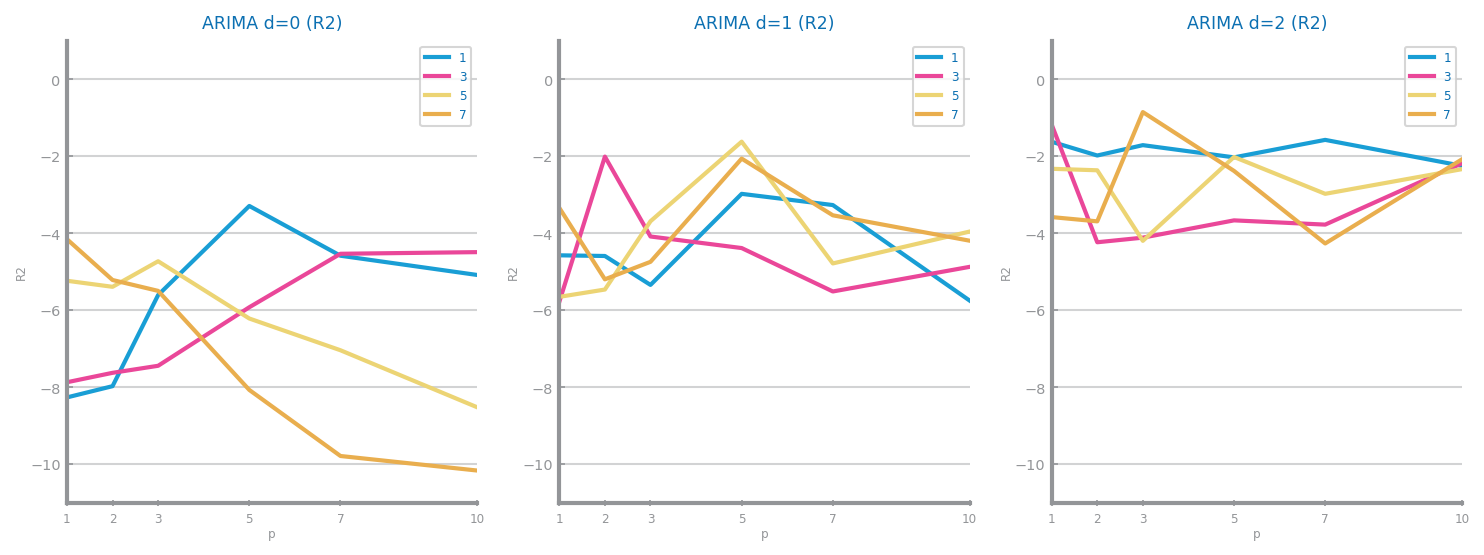

In [20]:
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE

def plot_multiline_chart(
    xvalues: list,
    yvalues: dict,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    percentage: bool = False,
) -> Axes:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    ax = set_chart_xticks(xvalues, ax=ax, percentage=percentage)
    legend: list = []
    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
        if any(v < 0 for v in y) and percentage:
            ax.set_ylim(-11, 1.0)
    ax.legend(legend, fontsize="xx-small")
    return ax


def arima_study(train: Series, test: Series, measure: str = "R2"):
    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                arima = ARIMA(train, order=(p, d, q))
                model = arima.fit()
                prd_tst = model.forecast(steps=len(test), signal_only=False)
                eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                # print(f"ARIMA ({p}, {d}, {q})", eval)
                if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                    best_performance: float = eval
                    best_params["params"] = (p, d, q)
                    best_model = model
                yvalues.append(eval)
            values[q] = yvalues
        print(values)
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params


best_model, best_params = arima_study(train, test, measure=measure)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting study over different parameterisations of the ARIMA algorithm, only with the target variable.png", bbox_inches='tight')

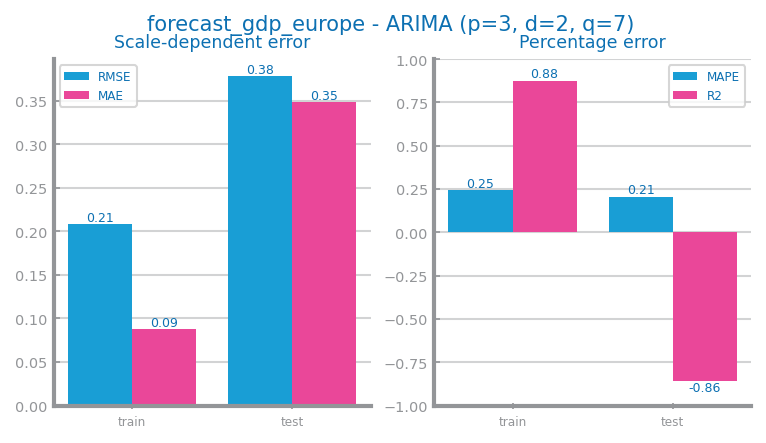

In [21]:
params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(
    train, test, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results obtained with the best parameterisation of ARIMA algorithm, only with the target variable.png", bbox_inches='tight')

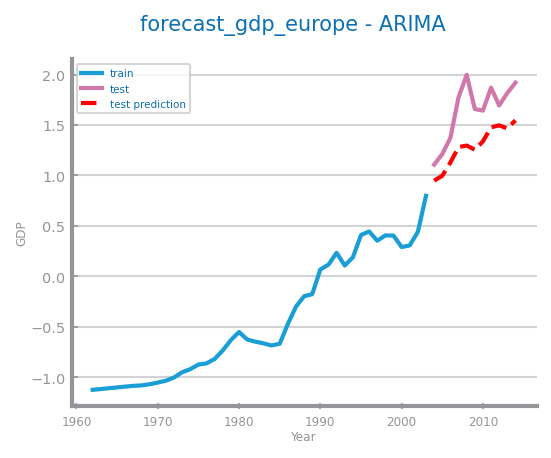

In [22]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - ARIMA ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots obtained with the best parameterisation of ARIMA algorithm, only with the target variable.png", bbox_inches='tight')

### Multiple variables

In [23]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.arima.model import ARIMA
# from dslabs_functions import series_train_test_split, HEIGHT

def series_train_test_split_exog(data: DataFrame, trn_pct: float = 0.90) -> tuple[Series, Series, DataFrame, DataFrame]:
    trn_size: int = int(len(data) * trn_pct)
    target: Series = data.iloc[:, -1]  # Assuming the target is the last column
    exog: DataFrame = data.iloc[:, :-1]  # All columns except the last one
    
    train_target: Series = target.iloc[:trn_size]
    test_target: Series = target.iloc[trn_size:]
    train_exog: DataFrame = exog.iloc[:trn_size]
    test_exog: DataFrame = exog.iloc[trn_size:]
    
    return train_target, test_target, train_exog, test_exog


data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]
train_target, test_target, train_exog, test_exog = series_train_test_split_exog(data, trn_pct=0.80)

# predictor = ARIMA(train_target, exog=train_exog, order=(3, 1, 2))
# model = predictor.fit()
# print(model.summary())

In [24]:
# model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))

/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/morais/data_science_project/.venv/l

{1: [-3.4153493452314025, -3.8229225711190438, -4.707433535152799, -4.237265244112371, -4.27544496216987, -6.723025215725701], 2: [-4.321304703519409, -9.451124910697635, -9.343421924574137, -9.494074119750247, -3.810505585302203, -6.5464793992945935], 3: [-4.349517254616346, -7.6060501855405604, -2.3513840783623214, -4.3051336376146985, -2.5151868110045843, -6.553918732688273], 5: [-7.876509979365304, -8.745108046263551, -6.975803149479768, -2.424918003312454, -2.6701018300599673, -10.648857518684801], 7: [-7.346297825977212, -8.144088354540628, -7.129846155153867, -7.294009479037934, -6.732560905305816, -9.785157072817748]}


/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/morais/data_science_project/.venv/l

{1: [-1.7489048557690667, -2.47549121656242, -0.9983066117317227, -1.6594639319364575, -2.667078171489592, -3.938222447751592], 2: [-3.7809469498308195, -4.087966829324634, -1.6965911309326542, -2.51033915183216, -2.7052439899092966, -4.163738202936799], 3: [-1.1223114281400415, -2.3618382912759257, -2.7877997679724316, -1.209231953144188, -2.6203717279428687, -3.8837503736656176], 5: [-0.8295611295525904, -2.2936349504264513, -1.7669797461563306, -1.9328776168659831, -2.6174463914990027, -4.051683194331257], 7: [-2.952111999442405, -7.0425299148442395, -6.883430488307285, -4.346996848682999, -3.068374466731232, -4.144963983457237]}


/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/home/morais/data_science_project/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/morais/data_science_project/.venv/l

{1: [0.5141040246944428, -2.704884355289912, -1.8688892206181151, -1.310999507012827, -0.10312100599425267, -0.3780395895758011], 2: [0.39269587416639296, 0.27203280753665404, 0.3379490164617611, -0.22633820682767936, -0.06045288005452365, -0.8452918484161214], 3: [-0.03744151325657086, -15.531778392614008, -0.5019983499476566, 0.04450911494854504, -1.0697336864601006, -0.739603486337338], 5: [0.5255840979179042, -0.24757534665570535, -0.611392907590016, -0.023252234191848853, -0.7828740696940306, -0.9183248332104643], 7: [0.027656870257794286, 0.7528773167807226, 0.7452255577864257, 0.5927901740770842, -0.5070956573482912, -1.4924866967651367]}
ARIMA best results achieved with (p,d,q)=(2, 2, 7) ==> measure=0.75


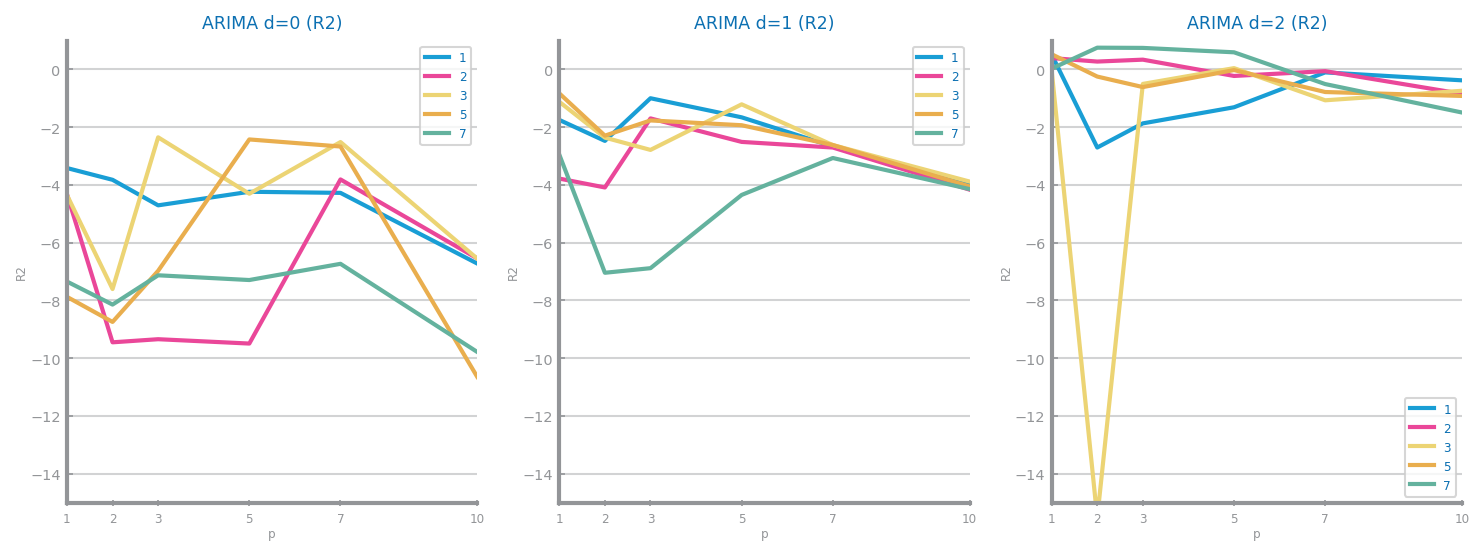

In [25]:
def plot_multiline_chart(
    xvalues: list,
    yvalues: dict,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    percentage: bool = False,
) -> Axes:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    ax = set_chart_xticks(xvalues, ax=ax, percentage=percentage)
    legend: list = []
    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
        if any(v < 0 for v in y) and percentage:
            ax.set_ylim(-15.0, 1.0)
    ax.legend(legend, fontsize="xx-small")
    return ax


def arima_study(train: Series, test: Series, train_exog: Series, test_exog: Series, measure: str = "R2"):
    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 2, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                arima = ARIMA(train, exog=train_exog, order=(p, d, q))
                model = arima.fit()
                prd_tst = model.forecast(steps=len(test), signal_only=False, exog=test_exog)
                eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                # print(f"ARIMA ({p}, {d}, {q})", eval)
                if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                    best_performance: float = eval
                    best_params["params"] = (p, d, q)
                    best_model = model
                yvalues.append(eval)
            values[q] = yvalues
        print(values)
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params


best_model, best_params = arima_study(train_target, test_target, train_exog=train_exog, test_exog=test_exog, measure=measure)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting study over different parameterisations of the ARIMA algorithm with multiple variables.png", bbox_inches='tight')

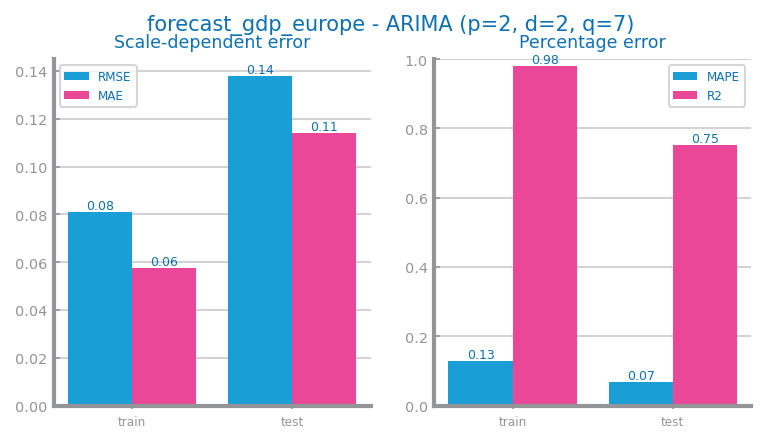

In [26]:
params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train_target) - 1, exog=train_exog)
prd_tst = best_model.forecast(steps=len(test_target), exog=test_exog)

plot_forecasting_eval(
    train_target, test_target, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results obtained with the best parameterisation of ARIMA algorithm with multiple variables.png", bbox_inches='tight')

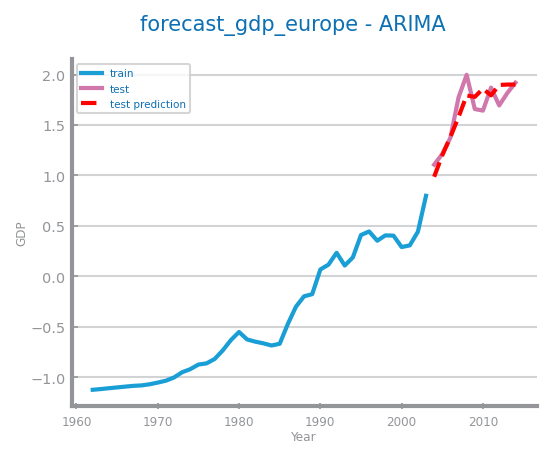

In [27]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - ARIMA ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots obtained with the best parameterisation of ARIMA algorithm with multiple variables.png", bbox_inches='tight')

## **LSTMs**
### Only with target variable

In [28]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


def prepare_dataset_for_lstm(series, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]
        future = series[i + 1 : i + seq_length + 1]
        setX.append(past)
        setY.append(future)
    return tensor(setX), tensor(setY)


class DS_LSTM(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
        # self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=max(1, len(train) // 10))

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]
    
from pandas import read_csv, DataFrame, Series


# filename: str = "data/time_series/ashrae.csv"
# file_tag: str = "ASHRAE"
# target: str = "meter_reading"
# timecol: str = "timestamp"

# measure: str = "R2"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series = data[[target]].values.astype("float32")

train_size = int(len(series) * 0.80)
train, test = series[:train_size], series[train_size:]

# model = DS_LSTM(train, input_size=1, hidden_size=50, num_layers=1)
# loss = model.fit()
# print(loss)

seq length=2 hidden_units=25 nr_episodes=0 -124.19316864013672
seq length=2 hidden_units=25 nr_episodes=300 -29.809682846069336
seq length=2 hidden_units=25 nr_episodes=600 -42.20848846435547
seq length=2 hidden_units=25 nr_episodes=900 -51.23810577392578
seq length=2 hidden_units=25 nr_episodes=1200 -55.26329803466797
seq length=2 hidden_units=25 nr_episodes=1500 -58.1568603515625
seq length=2 hidden_units=25 nr_episodes=1800 -48.57527542114258
seq length=2 hidden_units=25 nr_episodes=2100 -40.59284973144531
seq length=2 hidden_units=25 nr_episodes=2400 -35.58099365234375
seq length=2 hidden_units=25 nr_episodes=2700 -32.851497650146484
seq length=2 hidden_units=25 nr_episodes=3000 -31.54987335205078
seq length=2 hidden_units=50 nr_episodes=0 -116.19982147216797
seq length=2 hidden_units=50 nr_episodes=300 -26.545005798339844
seq length=2 hidden_units=50 nr_episodes=600 -41.86052703857422
seq length=2 hidden_units=50 nr_episodes=900 -56.32891082763672
seq length=2 hidden_units=50 nr_e

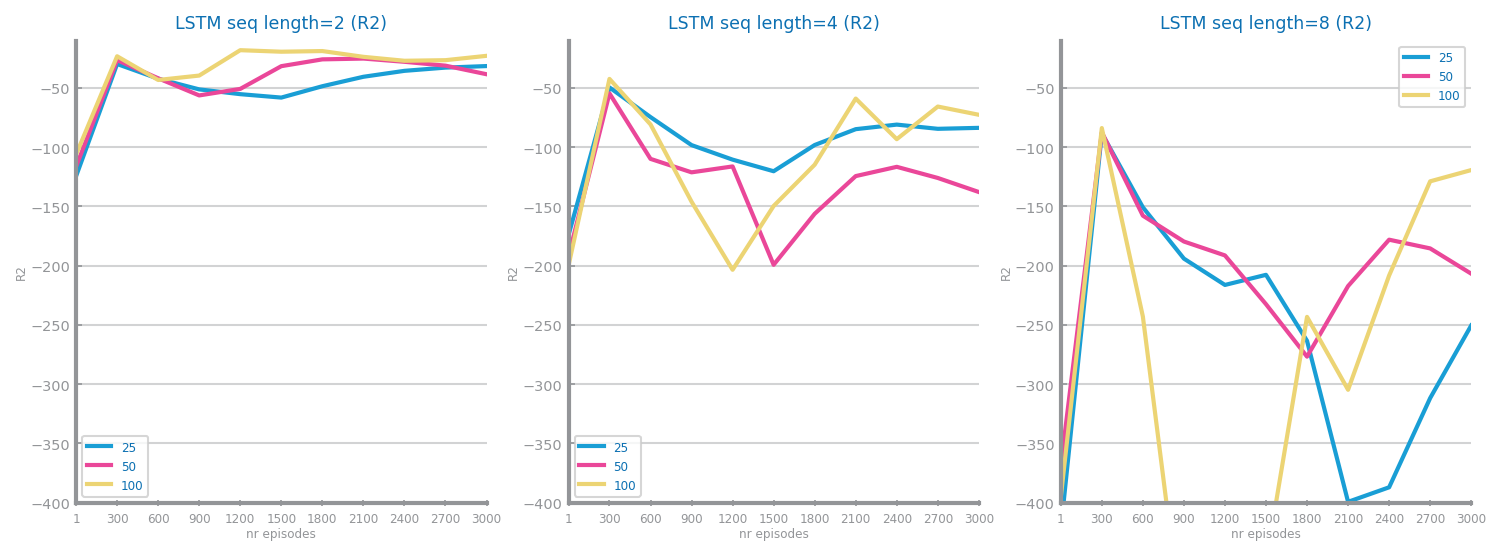

In [29]:
from copy import deepcopy

from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE


def plot_multiline_chart(
    xvalues: list,
    yvalues: dict,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    percentage: bool = False,
) -> Axes:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    ax = set_chart_xticks(xvalues, ax=ax, percentage=percentage)
    legend: list = []
    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
        if any(v < 0 for v in y) and percentage:
            ax.set_ylim(-400.0, -10.0)
    ax.legend(legend, fontsize="xx-small")
    return ax


def lstm_study(train, test, nr_episodes: int = 1000, measure: str = "R2"):
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(train, hidden_size=hidden)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = FORECAST_MEASURES[measure](test[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params['params'][0]} hidden_units={best_params['params'][1]} and nr_episodes={best_params['params'][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


best_model, best_params = lstm_study(train, test, nr_episodes=3000, measure=measure)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting study over different parameterisations of LSTMs, only with the target variable.png", bbox_inches='tight')

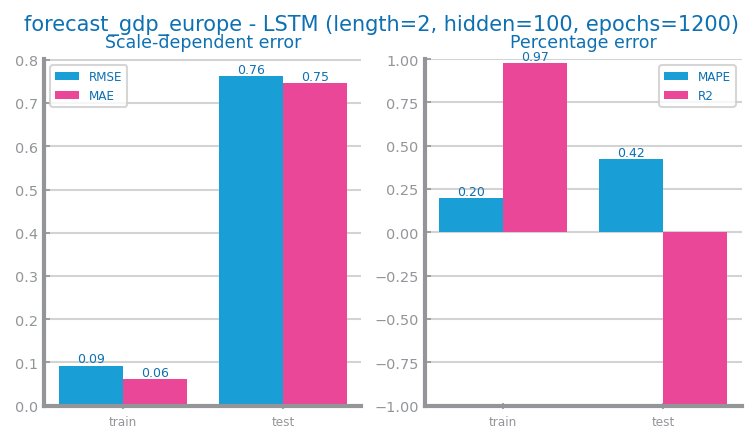

In [30]:
params = best_params["params"]
best_length = params[0]
trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_forecasting_eval(
    train[best_length:],
    test[best_length:],
    prd_trn,
    prd_tst,
    title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})",
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results obtained with the best parameterisation of LSTMs, only with the target variable.png", bbox_inches='tight')

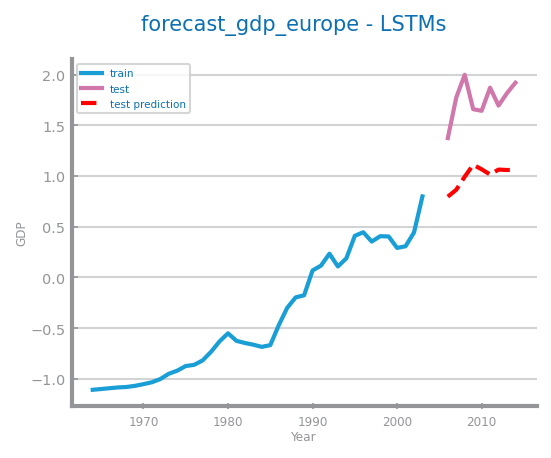

In [31]:
series = data[[target]]
train, test = series[:train_size], series[train_size:]
pred_series: Series = Series(prd_tst.numpy().ravel(), index=test.index[best_length:])

plot_forecasting_series(
    train[best_length:],
    test[best_length:],
    pred_series,
    title=f"{file_tag} - LSTMs ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots obtained with the best parameterisation of LSTMs, only with the target variable.png", bbox_inches='tight')

### Multiple variables

In [32]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


def prepare_dataset_for_lstm(data, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(data) - seq_length):
        past = data[i : i + seq_length, :]  # All features
        future = data[i + 1 : i + seq_length + 1, 0]  # Only the target variable
        setX.append(past)
        setY.append(future)
    return tensor(setX), tensor(setY)



class DS_LSTM(Module):
    def __init__(self, train, input_size: int, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)  # Output size is 1 (target variable)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)  # x: (batch, seq_length, hidden_size)
        x = self.linear(x)  # x: (batch, seq_length, 1)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred[:, -1, :], batchY[:, -1])  # Compare only the last step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss.item()

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]  # Return prediction for the last step



data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series = data.values.astype("float32")  # Use all features

train_size = int(len(series) * 0.80)
train, test = series[:train_size], series[train_size:]

input_size = train.shape[1]  # Number of features
# model = DS_LSTM(train, input_size=input_size, hidden_size=50, num_layers=1)
# loss = model.fit()
# print(loss)

seq length=2 hidden_units=25 nr_episodes=0 -55.58754348754883
seq length=2 hidden_units=25 nr_episodes=300 -50.9266242980957
seq length=2 hidden_units=25 nr_episodes=600 -65.89203643798828
seq length=2 hidden_units=25 nr_episodes=900 -63.82079315185547
seq length=2 hidden_units=25 nr_episodes=1200 -63.336647033691406
seq length=2 hidden_units=25 nr_episodes=1500 -57.34306716918945
seq length=2 hidden_units=25 nr_episodes=1800 -64.63114929199219
seq length=2 hidden_units=25 nr_episodes=2100 -57.24217224121094
seq length=2 hidden_units=25 nr_episodes=2400 -63.108116149902344
seq length=2 hidden_units=25 nr_episodes=2700 -67.60371398925781
seq length=2 hidden_units=25 nr_episodes=3000 -54.20736312866211
seq length=2 hidden_units=50 nr_episodes=0 -82.58013916015625
seq length=2 hidden_units=50 nr_episodes=300 -59.56113815307617
seq length=2 hidden_units=50 nr_episodes=600 -51.34635543823242
seq length=2 hidden_units=50 nr_episodes=900 -63.039100646972656
seq length=2 hidden_units=50 nr_epi

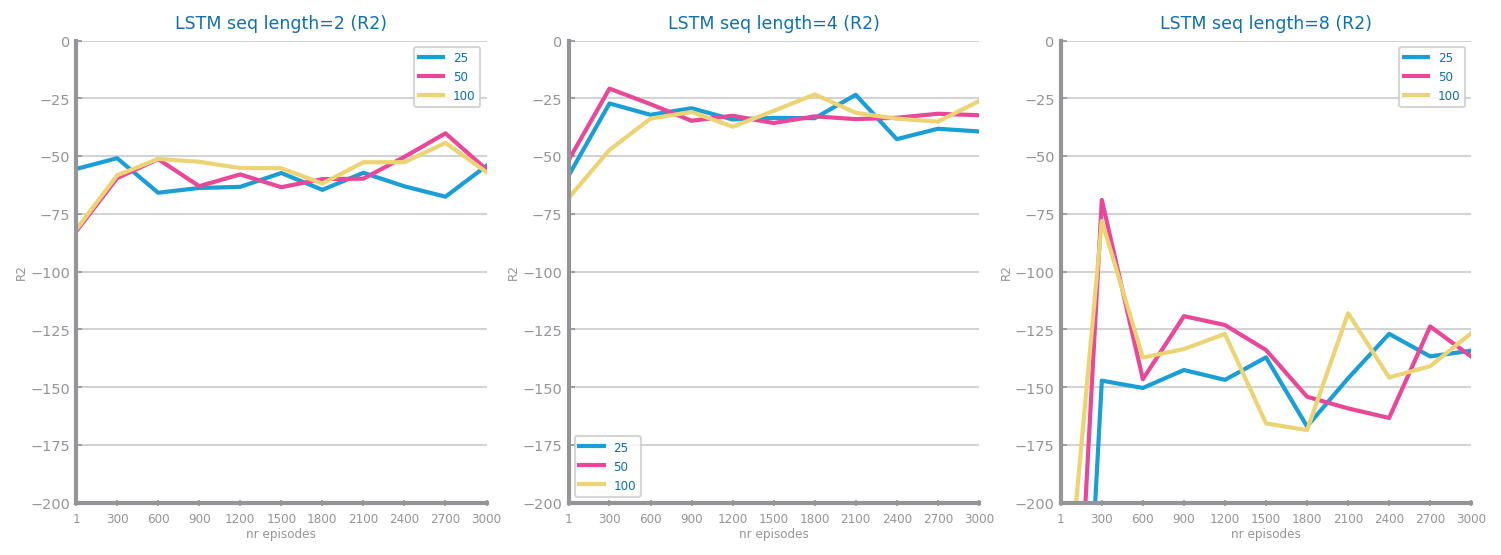

In [33]:
def plot_multiline_chart(
    xvalues: list,
    yvalues: dict,
    ax: Axes = None,  # type: ignore
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    percentage: bool = False,
) -> Axes:
    if ax is None:
        ax = gca()
    ax = set_chart_labels(ax=ax, title=title, xlabel=xlabel, ylabel=ylabel)
    ax = set_chart_xticks(xvalues, ax=ax, percentage=percentage)
    legend: list = []
    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
        if any(v < 0 for v in y) and percentage:
            ax.set_ylim(-200.0, 0.0)
    ax.legend(legend, fontsize="xx-small")
    return ax

def lstm_study(train, test, nr_episodes: int = 1000, measure: str = "R2"):
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)

        input_size = train.shape[1]  # Number of features
        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(train, input_size=input_size, hidden_size=hidden, length=length)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    # Evaluate only the target variable
                    eval: float = FORECAST_MEASURES[measure](test[length:, 0], prd_tst.numpy().flatten())
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params['params'][0]} hidden_units={best_params['params'][1]} and nr_episodes={best_params['params'][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params

best_model, best_params = lstm_study(train, test, nr_episodes=3000, measure="R2")
savefig(f"{path_to_directory}/images/Set 2 - Forecasting study over different parameterisations of LSTMs with multiple variables.png", bbox_inches='tight')

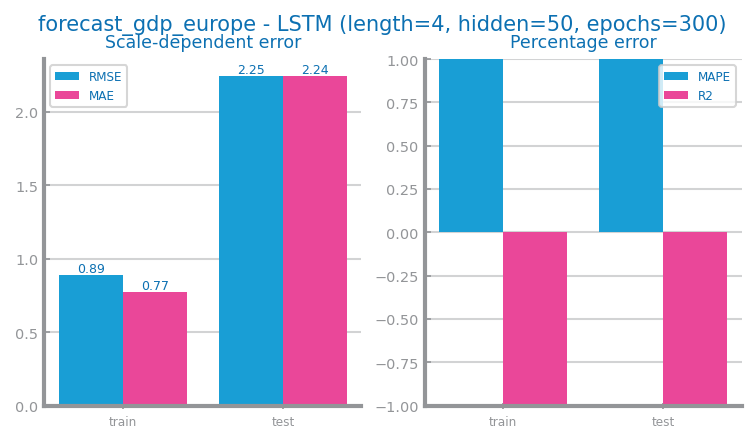

In [34]:
def plot_forecasting_eval(trn: Series, tst: Series, prd_trn: Series, prd_tst: Series, title: str = "") -> list[Axes]:
    ev1: dict = {
        "RMSE": [sqrt(FORECAST_MEASURES["MSE"](trn, prd_trn)), sqrt(FORECAST_MEASURES["MSE"](tst, prd_tst))],
        "MAE": [FORECAST_MEASURES["MAE"](trn, prd_trn), FORECAST_MEASURES["MAE"](tst, prd_tst)],
    }
    ev2: dict = {
        "MAPE": [FORECAST_MEASURES["MAPE"](trn, prd_trn), FORECAST_MEASURES["MAPE"](tst, prd_tst)],
        "R2": [FORECAST_MEASURES["R2"](trn, prd_trn), FORECAST_MEASURES["R2"](tst, prd_tst)],
    }

    # print(eval1, eval2)
    fig, axs = subplots(1, 2, figsize=(1.5 * HEIGHT, 0.75 * HEIGHT), squeeze=True)
    fig.suptitle(title)
    plot_multibar_chart(["train", "test"], ev1, ax=axs[0], title="Scale-dependent error", percentage=False)
    plot_multibar_chart(["train", "test"], ev2, ax=axs[1], title="Percentage error", percentage=True)

    return axs

params = best_params["params"]
best_length = params[0]
trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

# Extract only the last column from `trn` and `tst` for comparison
trn_last = train[best_length:, -1]
tst_last = test[best_length:, -1]

# Use the prd_trn and prd_tst directly as they are
prd_trn_last = prd_trn.squeeze()  # Convert tensor to 1D array if needed
prd_tst_last = prd_tst.squeeze()  # Convert tensor to 1D array if needed

# Ensure shapes match for evaluation
assert len(trn_last) == len(prd_trn_last), "Training data and predictions have mismatched lengths."
assert len(tst_last) == len(prd_tst_last), "Test data and predictions have mismatched lengths."

# Call the evaluation and plotting function
plot_forecasting_eval(
    trn_last,
    tst_last,
    prd_trn_last,
    prd_tst_last,
    title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})",
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting results obtained with the best parameterisation of LSTMs with multiple variables.png", bbox_inches='tight')

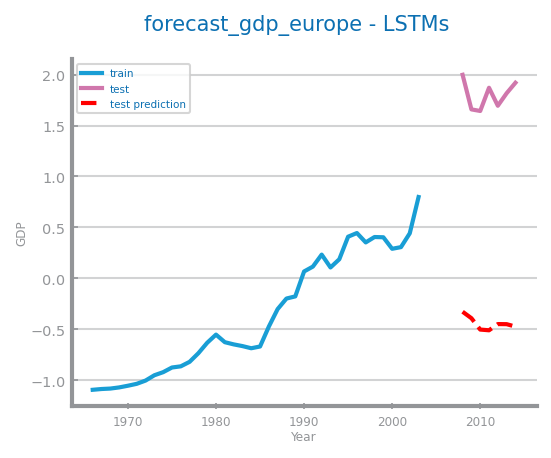

In [35]:
series = data[[target]]
train, test = series[:train_size], series[train_size:]
pred_series: Series = Series(prd_tst.numpy().ravel(), index=test.index[best_length:])

plot_forecasting_series(
    train[best_length:],
    test[best_length:],
    pred_series,
    title=f"{file_tag} - LSTMs",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"{path_to_directory}/images/Set 2 - Forecasting plots obtained with the best parameterisation of LSTMs with multiple variables.png", bbox_inches='tight')